# 01 - Data Audit

## Objective
Perform comprehensive data quality checks and exploratory analysis on the TCGA-BRCA dataset before modeling.

## Contents
1. Load and validate data files
2. Check sample ID overlap between expression and label tables
3. Examine label distribution (class imbalance)
4. Inspect gene expression value ranges (raw counts vs normalized)
5. Check for missing values and constant features
6. Visualize key distributions


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import random
import warnings

In [30]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
TABLES_DIR = REPORTS_DIR / "tables"

for d in [FIGURES_DIR, TABLES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

EXPRESSION_FILE = "HiSeqV2.csv"
PAM50_LABELS_FILE = "brca_pam50.csv.csv"

RANDOM_SEED = 42
CV_FOLDS = 5
VARIANCE_THRESHOLD = 0.01
LOG_TRANSFORM_THRESHOLD = 100

SAMPLE_ID_CANDIDATES = ["sample", "sample_id", "patient_id", "barcode", "Sample", "SAMPLE_ID"]
PAM50_LABEL_CANDIDATES = ["PAM50", "pam50", "Subtype", "subtype", "label", "Label"]
EXCLUDED_LABELS = ["Unknown", "unknown", "NA", "N/A", "", None]

PAM50_SUBTYPES = ["LumA", "LumB", "Her2", "Basal", "Normal"]
PAM50_COLORS = {
    "LumA": "#3498db", "LumB": "#2ecc71", "Her2": "#e74c3c",
    "Basal": "#9b59b6", "Normal": "#f39c12",
}

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

plt.rcParams.update({
    "figure.dpi": 100, "savefig.dpi": 150, "font.size": 10,
    "axes.labelsize": 11, "axes.titlesize": 12, "legend.fontsize": 9,
    "figure.figsize": (8, 6), "axes.spines.top": False, "axes.spines.right": False,
})

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")

Project root: c:\Users\noyab\Downloads\medicalproject
Data directory: c:\Users\noyab\Downloads\medicalproject\data


In [31]:
def normalize_sample_id(sample_id: str) -> str:
    """Normalize TCGA barcode to first 15 characters."""
    sample_id = str(sample_id).strip()
    if sample_id.startswith("TCGA-") and len(sample_id) >= 15:
        return sample_id[:15]
    return sample_id


def load_expression_data(filepath):
    """Load gene expression CSV, detect orientation, return (samples x genes) DataFrame."""
    print(f"Loading expression data from {filepath}...")
    df = pd.read_csv(filepath, index_col=0)
    print(f"  Raw shape: {df.shape}")

    first_col_tcga = any(str(c).startswith("TCGA-") for c in df.columns[:10])
    first_row_tcga = any(str(c).startswith("TCGA-") for c in df.index[:10])

    if first_col_tcga and not first_row_tcga:
        print("  Detected: genes as rows, samples as columns -> transposing")
        df = df.T
    elif first_row_tcga and not first_col_tcga:
        print("  Detected: samples as rows, genes as columns")
    elif df.shape[0] > df.shape[1]:
        print("  Inferred from shape: genes as rows -> transposing")
        df = df.T
    else:
        print("  Inferred from shape: samples as rows")

    df.index = [normalize_sample_id(s) for s in df.index]
    df.index.name = "sample_id"
    df = df.apply(pd.to_numeric, errors="coerce")
    print(f"  Final shape: {df.shape} (samples x genes)")
    return df


def load_pam50_labels(filepath):
    """Load PAM50 labels, normalise IDs, deduplicate, exclude invalid.
    
    Returns (labels_df, n_unique_after_dedup) where n_unique_after_dedup
    is the count AFTER deduplication but BEFORE Unknown exclusion.
    """
    print(f"Loading PAM50 labels from {filepath}...")
    df = pd.read_csv(filepath)
    print(f"  Raw shape: {df.shape}")

    sample_col = next((c for c in SAMPLE_ID_CANDIDATES if c in df.columns), df.columns[0])
    label_col = next((c for c in PAM50_LABEL_CANDIDATES if c in df.columns), df.columns[1])
    print(f"  Detected sample ID column: {sample_col}")
    print(f"  Detected PAM50 label column: {label_col}")

    labels_df = df[[sample_col, label_col]].copy()
    labels_df.columns = ["sample_id", "PAM50"]
    labels_df["sample_id"] = labels_df["sample_id"].apply(normalize_sample_id)

    n_raw = len(labels_df)
    labels_df = labels_df.drop_duplicates(subset="sample_id", keep="first")
    n_unique_after_dedup = len(labels_df)  
    n_dupes = n_raw - n_unique_after_dedup
    if n_dupes > 0:
        print(f"  Deduplicated: {n_raw} -> {n_unique_after_dedup} unique sample IDs ({n_dupes} duplicates removed)")

    valid_mask = ~labels_df["PAM50"].isin(EXCLUDED_LABELS)
    n_excluded = (~valid_mask).sum()
    if n_excluded > 0:
        print(f"  Excluding {n_excluded} samples with invalid labels: {labels_df[~valid_mask]['PAM50'].unique()}")
    labels_df = labels_df[valid_mask]

    print(f"  After Unknown exclusion: {len(labels_df)} labeled samples")
    print(f"  Label distribution: {labels_df['PAM50'].value_counts().to_dict()}")
    return labels_df, n_unique_after_dedup


def merge_data(expression_df, labels_df):
    """Merge expression data with labels by sample ID intersection."""
    print("\nMerging datasets...")
    expr_samples = set(expression_df.index)
    label_ids = set(labels_df["sample_id"])
    overlap = expr_samples & label_ids

    stats = {
        "n_expression_samples": len(expr_samples),
        "n_labeled_rows": len(labels_df),
        "n_matched_rows": labels_df["sample_id"].isin(overlap).sum(),
        "n_expr_only": len(expr_samples - label_ids),
        "n_label_only": len(label_ids - expr_samples),
    }
    print(f"  Expression samples: {stats['n_expression_samples']}")
    print(f"  Labeled samples: {stats['n_labeled_rows']}")
    print(f"  Matched to expression: {stats['n_matched_rows']}")
    print(f"  Expression only (unlabeled): {stats['n_expr_only']}")

    if len(overlap) == 0:
        raise ValueError("No overlapping samples found!")

    labels_df = labels_df[labels_df["sample_id"].isin(overlap)]
    X = expression_df.loc[labels_df["sample_id"].values]
    y = pd.Series(labels_df["PAM50"].values, index=X.index, name="PAM50")
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    class_counts = y.value_counts()
    if class_counts.min() < CV_FOLDS:
        warnings.warn(
            f"Class '{class_counts.idxmin()}' has only {class_counts.min()} sample(s), "
            f"which is less than CV_FOLDS={CV_FOLDS}. Stratified CV may need special handling."
        )

    print(f"\n  Final labeled dataset: {X.shape[0]} samples x {X.shape[1]} genes")
    return X, y, stats


def load_data():
    """Orchestrator: load expression + labels, merge, return X, y, X_unlabeled, info."""
    expression_path = DATA_DIR / EXPRESSION_FILE
    pam50_path = DATA_DIR / PAM50_LABELS_FILE

    expression_df = load_expression_data(expression_path)
    labels_df, n_unique_after_dedup = load_pam50_labels(pam50_path)
    X, y, merge_stats = merge_data(expression_df, labels_df)

    labeled_ids = set(labels_df["sample_id"])
    X_unlabeled = expression_df[~expression_df.index.isin(labeled_ids)]
    print(f"Unlabeled samples: {len(X_unlabeled)}")

    info = {"merge_stats": merge_stats, "n_unique_after_dedup": n_unique_after_dedup}
    return X, y, X_unlabeled, info

## 1. Load Data

In [32]:
X, y, X_unlabeled, info = load_data()

print("DATA LOADING COMPLETE")


Loading expression data from c:\Users\noyab\Downloads\medicalproject\data\HiSeqV2.csv...
  Raw shape: (20530, 1218)
  Detected: genes as rows, samples as columns -> transposing
  Final shape: (1218, 20530) (samples x genes)
Loading PAM50 labels from c:\Users\noyab\Downloads\medicalproject\data\brca_pam50.csv.csv...
  Raw shape: (141, 2)
  Detected sample ID column: sample
  Detected PAM50 label column: PAM50
  Deduplicated: 141 -> 74 unique sample IDs (67 duplicates removed)
  Excluding 4 samples with invalid labels: ['Unknown']
  After Unknown exclusion: 70 labeled samples
  Label distribution: {'LumB': 25, 'LumA': 18, 'Basal': 15, 'Her2': 11, 'Normal': 1}

Merging datasets...
  Expression samples: 1218
  Labeled samples: 70
  Matched to expression: 70
  Expression only (unlabeled): 1148

  Final labeled dataset: 70 samples x 20530 genes
Unlabeled samples: 1148
DATA LOADING COMPLETE


C:\Users\noyab\AppData\Local\Temp\ipykernel_14488\3077992341.py:103: UserWarning: Class 'Normal' has only 1 sample(s), which is less than CV_FOLDS=5. Stratified CV may need special handling.
  warnings.warn(


## 2. Data Summary

In [33]:
print("\n=== DATASET SUMMARY ===")
print(f"\nLabeled dataset (for supervised learning):")
print(f"  Samples: {X.shape[0]}")
print(f"  Features (genes): {X.shape[1]}")
print(f"  p/n ratio: {X.shape[1] / X.shape[0]:.1f}x (high-dimensional!)")
print(f"\nUnlabeled dataset (for inference only):")
print(f"  Samples: {X_unlabeled.shape[0]}")
print(f"\nTotal expression samples: {info['merge_stats']['n_expression_samples']}")


=== DATASET SUMMARY ===

Labeled dataset (for supervised learning):
  Samples: 70
  Features (genes): 20530
  p/n ratio: 293.3x (high-dimensional!)

Unlabeled dataset (for inference only):
  Samples: 1148

Total expression samples: 1218


## 3. Label Distribution (Class Imbalance)

In [34]:
print("\n=== PAM50 SUBTYPE DISTRIBUTION ===")
label_counts = y.value_counts()
label_pcts = (y.value_counts(normalize=True) * 100).round(1)

for subtype in PAM50_SUBTYPES:
    if subtype in label_counts.index:
        count = label_counts[subtype]
        pct = label_pcts[subtype]
        print(f"  {subtype:10s}: {count:3d} samples ({pct:5.1f}%)")

min_class = label_counts.min()
max_class = label_counts.max()
imbalance_ratio = max_class / min_class

print(f"\nClass imbalance ratio (max/min): {imbalance_ratio:.1f}")


=== PAM50 SUBTYPE DISTRIBUTION ===
  LumA      :  18 samples ( 25.7%)
  LumB      :  25 samples ( 35.7%)
  Her2      :  11 samples ( 15.7%)
  Basal     :  15 samples ( 21.4%)
  Normal    :   1 samples (  1.4%)

Class imbalance ratio (max/min): 25.0


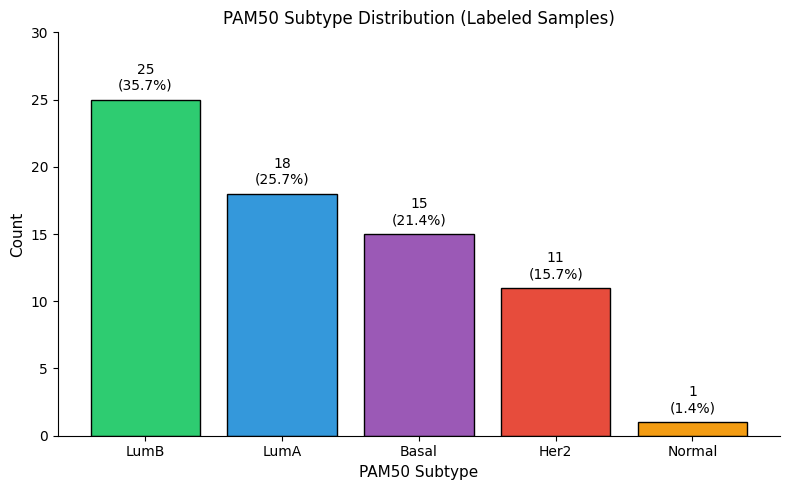

Saved label distribution to c:\Users\noyab\Downloads\medicalproject\reports\tables\label_distribution.csv


In [35]:
# Plot label distribution
counts = y.value_counts()
fig, ax = plt.subplots(figsize=(8, 5))
colors = [PAM50_COLORS.get(label, "#888888") for label in counts.index]
bars = ax.bar(counts.index, counts.values, color=colors, edgecolor="black")
ax.set_xlabel("PAM50 Subtype")
ax.set_ylabel("Count")
ax.set_title("PAM50 Subtype Distribution (Labeled Samples)")
for bar, count in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            f"{count}\n({100*count/len(y):.1f}%)", ha="center", va="bottom", fontsize=10)
ax.set_ylim(0, counts.max() * 1.2)
fig.tight_layout()
fig.savefig(FIGURES_DIR / "01_label_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

dist_df = pd.DataFrame({"Subtype": counts.index, "Count": counts.values,
                         "Percentage": (counts.values / len(y) * 100).round(1)})
dist_df.to_csv(TABLES_DIR / "label_distribution.csv", index=False)
print(f"Saved label distribution to {TABLES_DIR / 'label_distribution.csv'}")

## 4. Expression Value Analysis

In [36]:
print("\n=== EXPRESSION VALUE ANALYSIS ===")
print(f"\nValue range: [{X.values.min():.2f}, {X.values.max():.2f}]")
print(f"Mean: {X.values.mean():.2f}")
print(f"Median: {np.median(X.values):.2f}")
print(f"Std: {X.values.std():.2f}")

max_val = X.values.max()
if max_val > LOG_TRANSFORM_THRESHOLD:
    print(f"\nNOTE: Max value {max_val:.0f} > {LOG_TRANSFORM_THRESHOLD} suggests RAW COUNTS.")
    print("Log2(x+1) transformation will be applied during preprocessing.")
else:
    print(f"\nNOTE: Max value {max_val:.2f} <= {LOG_TRANSFORM_THRESHOLD} suggests data is ALREADY LOG-TRANSFORMED.")
    print("No additional log transform will be applied.")


=== EXPRESSION VALUE ANALYSIS ===

Value range: [0.00, 20.29]
Mean: 6.41
Median: 7.59
Std: 4.08

NOTE: Max value 20.29 <= 100 suggests data is ALREADY LOG-TRANSFORMED.
No additional log transform will be applied.


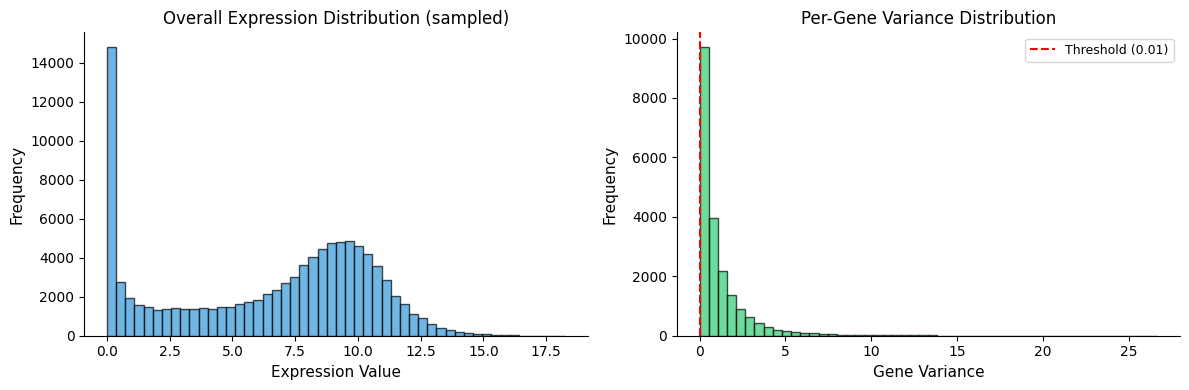


Genes with variance < 0.01: 909 (4.4%)


In [37]:
# Plot expression distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sample_vals = X.values.flatten()
sample_vals = np.random.choice(sample_vals[~np.isnan(sample_vals)],
                                size=min(100_000, len(sample_vals)), replace=False)
axes[0].hist(sample_vals, bins=50, color="#3498db", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Expression Value")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Overall Expression Distribution (sampled)")

gene_vars = X.var()
axes[1].hist(gene_vars, bins=50, color="#2ecc71", edgecolor="black", alpha=0.7)
axes[1].axvline(VARIANCE_THRESHOLD, color="red", linestyle="--",
                label=f"Threshold ({VARIANCE_THRESHOLD})")
axes[1].set_xlabel("Gene Variance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Per-Gene Variance Distribution")
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "01_expression_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

n_low_var = (gene_vars < VARIANCE_THRESHOLD).sum()
print(f"\nGenes with variance < {VARIANCE_THRESHOLD}: {n_low_var} ({100*n_low_var/len(gene_vars):.1f}%)")

## 5. Missing Values Check

In [38]:
print("\n=== MISSING VALUES CHECK ===")
n_missing = X.isna().sum().sum()
pct_missing = 100 * n_missing / X.size
print(f"\nTotal missing values: {n_missing} ({pct_missing:.4f}%)")

if n_missing > 0:
    print(f"Samples with any missing: {X.isna().any(axis=1).sum()}")
    print(f"Genes with any missing: {X.isna().any(axis=0).sum()}")
else:
    print("No missing values detected.")


=== MISSING VALUES CHECK ===

Total missing values: 0 (0.0000%)
No missing values detected.


## 6. Sample ID Analysis

In [39]:
print("\n=== SAMPLE ID ANALYSIS ===")
print(f"\nMerge statistics:")
for key, val in info["merge_stats"].items():
    print(f"  {key}: {val}")

print(f"\nSample IDs (first 5):")
print(f"  {list(X.index[:5])}")


=== SAMPLE ID ANALYSIS ===

Merge statistics:
  n_expression_samples: 1218
  n_labeled_rows: 70
  n_matched_rows: 70
  n_expr_only: 1148
  n_label_only: 0

Sample IDs (first 5):
  [0, 1, 2, 3, 4]


## 7. Challenge Summary

In [40]:
print("\n" + "=" * 60)
print("CHALLENGE SUMMARY")
print("=" * 60)

print(f"""
1. HIGH DIMENSIONALITY (p >> n)
   - {X.shape[1]:,} genes vs {X.shape[0]} samples
   - p/n ratio: {X.shape[1]/X.shape[0]:.0f}x
   - Risk: Overfitting, spurious correlations
   - Solution: Regularization (ElasticNet), feature selection

2. CLASS IMBALANCE
   - Smallest class: {label_counts.min()} samples ({label_counts.idxmin()})
   - Largest class: {label_counts.max()} samples ({label_counts.idxmax()})
   - Imbalance ratio: {imbalance_ratio:.1f}x
   - Solution: Stratified CV, balanced class weights, Macro-F1

3. MULTICOLLINEARITY
   - Many genes are co-expressed in pathways
   - Risk: Unstable coefficient estimates
   - Solution: ElasticNet (L1 selects, L2 stabilizes)

4. LIMITED LABELED DATA
   - Only {X.shape[0]} labeled samples available
   - {X_unlabeled.shape[0]} unlabeled (cannot evaluate)
   - Solution: Cross-validation, conservative evaluation
""")

print("=" * 60)
print("Data audit complete. Proceed to modeling.")
print("=" * 60)


CHALLENGE SUMMARY

1. HIGH DIMENSIONALITY (p >> n)
   - 20,530 genes vs 70 samples
   - p/n ratio: 293x
   - Risk: Overfitting, spurious correlations
   - Solution: Regularization (ElasticNet), feature selection

2. CLASS IMBALANCE
   - Smallest class: 1 samples (Normal)
   - Largest class: 25 samples (LumB)
   - Imbalance ratio: 25.0x
   - Solution: Stratified CV, balanced class weights, Macro-F1

3. MULTICOLLINEARITY
   - Many genes are co-expressed in pathways
   - Risk: Unstable coefficient estimates
   - Solution: ElasticNet (L1 selects, L2 stabilizes)

4. LIMITED LABELED DATA
   - Only 70 labeled samples available
   - 1148 unlabeled (cannot evaluate)
   - Solution: Cross-validation, conservative evaluation

Data audit complete. Proceed to modeling.


In [41]:
truth_table = {
    "raw_label_rows": 141,
    "unique_after_dedup": int(info["n_unique_after_dedup"]),
    "after_unknown_exclusion": int(info["merge_stats"]["n_labeled_rows"]),
    "used_in_training": int((y != "Normal").sum()),
    "normal_excluded": int((y == "Normal").sum()),
    "unlabeled": int(X_unlabeled.shape[0]),
    "expression_samples": int(info["merge_stats"]["n_expression_samples"]),
    "n_genes": int(X.shape[1]),
    "label_distribution": {str(k): int(v) for k, v in y.value_counts().items()},
}

with open(TABLES_DIR / "data_truth_table.json", "w", encoding="utf-8") as f:
    json.dump(truth_table, f, indent=2)
print(f"Saved data_truth_table.json")
print(f"  Data provenance: {truth_table['raw_label_rows']} raw -> "
      f"{truth_table['unique_after_dedup']} unique -> "
      f"{truth_table['after_unknown_exclusion']} after Unknown exclusion -> "
      f"{truth_table['used_in_training']} in training")

audit_summary = {
    "n_labeled_samples": int(X.shape[0]),
    "n_unlabeled_samples": int(X_unlabeled.shape[0]),
    "n_genes": int(X.shape[1]),
    "p_n_ratio": round(X.shape[1] / X.shape[0], 1),
    "label_distribution": {str(k): int(v) for k, v in y.value_counts().items()},
    "imbalance_ratio": round(float(imbalance_ratio), 2),
    "min_class": str(label_counts.idxmin()),
    "min_class_count": int(label_counts.min()),
    "value_range": [float(X.values.min()), float(X.values.max())],
    "likely_log_transformed": bool(X.values.max() <= LOG_TRANSFORM_THRESHOLD),
    "missing_pct": round(float(pct_missing), 4),
    "low_variance_genes": int(n_low_var),
}

with open(TABLES_DIR / "data_audit_summary.json", "w", encoding="utf-8") as f:
    json.dump(audit_summary, f, indent=2)
print(f"Saved data_audit_summary.json")

Saved data_truth_table.json
  Data provenance: 141 raw -> 74 unique -> 70 after Unknown exclusion -> 69 in training
Saved data_audit_summary.json
